In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import gc

In [7]:
val_dataset = datasets.VOCSegmentation(root='tmp', image_set='val', download=True)

Using downloaded and verified file: tmp/VOCtrainval_11-May-2012.tar
Extracting tmp/VOCtrainval_11-May-2012.tar to tmp


In [13]:
train_dataset = datasets.VOCSegmentation(root='tmp', image_set='train', download=True)

Using downloaded and verified file: tmp/VOCtrainval_11-May-2012.tar
Extracting tmp/VOCtrainval_11-May-2012.tar to tmp


In [14]:
train_dataset

Dataset VOCSegmentation
    Number of datapoints: 1464
    Root location: tmp

In [15]:
val_dataset

Dataset VOCSegmentation
    Number of datapoints: 1449
    Root location: tmp

## Custom Dataset 

Custom dataset to filter out only images that contain a specific class.
The mask is filtered accordingly.

In [16]:
class CustomBinarySegmentationDataset(Dataset):
    def __init__(self, dataset, foreground_class_id, transform=None, target_transform=None):
        self.voc_dataset = dataset
        self.foreground_class_id = foreground_class_id
        self.transform = transform
        self.target_transform = target_transform

        # Create a list of indices for images with the foreground class
        self.indices = [idx for idx, sample in enumerate(self.voc_dataset) if np.any(np.array(sample[1]) == foreground_class_id)]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample = self.voc_dataset[self.indices[idx]]

        image = sample[0]
        mask = sample[1]
        
        # careful: must remember the state so that the same transformation is applied to both
        # input and target images the same way
        state = torch.get_rng_state()
        if self.transform is not None:
            image = self.transform(image).float()

        if self.target_transform is not None:
            torch.set_rng_state(state)
            mask = self.target_transform(mask).float()
            boolean_mask = (mask == self.foreground_class_id)
            masked_tensor = torch.where(boolean_mask, mask, torch.tensor(0))

        return {0: image, 1: masked_tensor}

In [18]:
# given the small size of the dataset, add random agumentations to synthetically 
# increase the size of the dataset.
transform = transforms.Compose([
    transforms.Resize((256,512)),
    transforms.PILToTensor(),
#     transforms.RandomRotation((-30,30)),
    transforms.RandomAffine(degrees=(-30,30),translate=(0.2,0.2),scale=(0.9,1.2)),
#     transforms.RandomVerticalFlip(0.3),
    transforms.RandomHorizontalFlip(0.3),
])

binary_train_dataset = CustomBinarySegmentationDataset(train_dataset, 1, transform=transform, target_transform=transform)
binary_val_dataset = CustomBinarySegmentationDataset(val_dataset, 1, transform=transform, target_transform=transform)

In [22]:
print(len(binary_train_dataset), len(binary_val_dataset))

88 90


In [23]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda


In [111]:
train_dataloader = torch.utils.data.DataLoader(binary_train_dataset, batch_size=8,
                                         shuffle=True, num_workers=2)

val_dataloader = torch.utils.data.DataLoader(binary_val_dataset, batch_size=8,
                                         shuffle=True, num_workers=2)
batch = next(iter(train_dataloader))
val_batch = next(iter(val_dataloader))

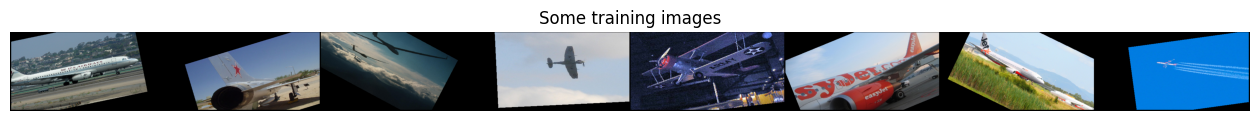

In [44]:
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Some training images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=4, normalize=True).cpu(),(1,2,0)))

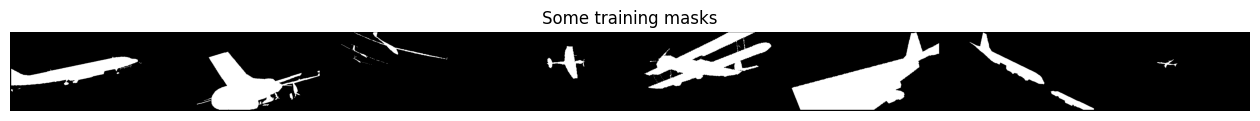

In [46]:
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Some training masks")
plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:64], padding=4, normalize=True).cpu(),(1,2,0)))

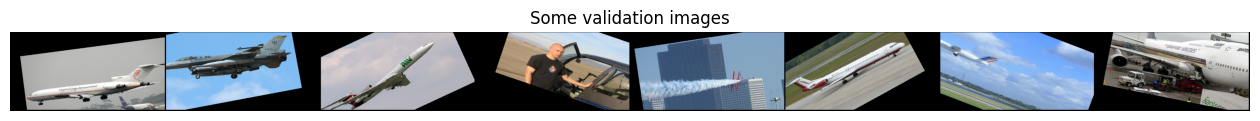

In [45]:
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Some validation images")
plt.imshow(np.transpose(vutils.make_grid(val_batch[0].to(device)[:64], padding=4, normalize=True).cpu(),(1,2,0)))

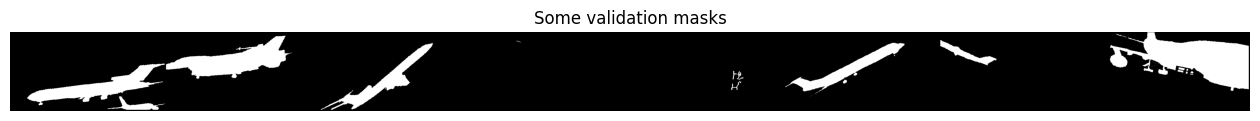

In [48]:
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Some validation masks")
plt.imshow(np.transpose(vutils.make_grid(val_batch[1].to(device)[:64], padding=4, normalize=True).cpu(),(1,2,0)))

## Model definition

In [55]:
class DownConv(torch.nn.Module):
        '''
        Performs 2 convolution and a pooling operation, reducing the image size image size
        while increasing the number of features.
        '''
        def __init__(self, in_channels, out_channels):
            super().__init__()
            
            self.conv = UNetDoubleConv(in_channels, out_channels)
            self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        def forward(self, x):
            skip_connection = self.conv(x)
            x = self.pool(skip_connection)
            
            return x, skip_connection
        
class UpConv(torch.nn.Module):
        '''
        Performs a transpose convolution and two convolutions, increasing the image size
        and reducing the features.
        '''
        def __init__(self, in_channels, out_channels):
            super().__init__()
            
            self.conv_trans = torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
            self.conv = UNetDoubleConv(in_channels, out_channels)
            
        def forward(self, x, skip_connection):
            up = self.conv_trans(x)
            x_and_skip = torch.cat([skip_connection, up], dim=1)
            return self.conv(x_and_skip)
        
class UNetDoubleConv(torch.nn.Module):
        '''
        Performs 2 convolutions, interleaved by a batch-norm and an activation (relu).
        '''
        def __init__(self, in_channels, out_channels):
            super().__init__()

            self.convs = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 3,1,1, bias=False),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(out_channels, out_channels, 3,1,1, bias=False),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU(inplace=True )
            )

        def forward(self, x):
            return self.convs(x)

class UNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels, inner_channels=[64,128,256,512]):
        super().__init__()
        self.inner_channels = inner_channels
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Down convolutions in the U-net
        self.downs = torch.nn.ModuleList()
        for features in self.inner_channels:
            self.downs.append(DownConv(in_channels, features))
            in_channels = features
        
        # Up convolutions in the U-net
        self.ups = torch.nn.ModuleList()
        for features in  reversed(self.inner_channels):
            self.ups.append(UpConv(features*2, features))
            
        self.bottleneck = UNetDoubleConv(self.inner_channels[-1], self.inner_channels[-1]*2)
        
        self.final_layer = torch.nn.Conv2d(inner_channels[0], self.out_channels, kernel_size=1)
        
    
    def forward(self, x):
        skip_connections = []
        
        for down in self.downs:
            x, skip_conn = down(x)
            skip_connections.insert(0, skip_conn)
#             print(skip_conn.size())
            
        x = self.bottleneck(x)
#         print('bottleneck', x.size())
        
        for i, up in enumerate(self.ups):
            skip_conn = skip_connections[i]
            x = up(x, skip_conn)
            del skip_conn
            gc.collect()
        
        x = self.final_layer(x)
            
        return x
            

In [56]:
in_batch = batch[0]

In [62]:
def get_num_params(model):
    return sum(param.numel() for param in model.parameters())

## Training

In [63]:
net = UNet(3, 1)
net = net.to(device)
print(get_num_params(net))

# num_GPUs = 2 # change accordingly

# if (device.type == 'cuda') and (num_GPUs > 1):
#     print(f'using {num_GPUs} GPUs')
#     net = torch.nn.DataParallel(net, list(range(num_GPUs)))

31037633


In [64]:
lr = 1e-4
num_epochs = 100
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# gradient accumulation 
grad_acc_for = 2 # 2 * 8 = 16 (synthetic batches of 16)

In [65]:
step_done = False

train_running_loss = 0
train_running_counter = 0

losses = []
val_losses = []
print('Training started.')
for epoch in range(num_epochs):
    for i, batch in enumerate(train_dataloader):
        net.train()
        if step_done:
            net.zero_grad()
            step_done = False
        
        in_batch, targets = batch[0].to(device), batch[1].to(device)
        out = net(in_batch)
        
        loss = loss_fn(out, targets)
        loss.backward()
        
        
        losses.append(loss.item())
        train_running_loss += loss.item()
        train_running_counter += 1
        # print avg loss sometimes
        if i % 4 == 4 -1 or i == len(dataloader)-1:
            running_avg_loss = train_running_loss / train_running_counter
            train_running_loss = 0
            train_running_counter = 0
            print(f'[{epoch}/{num_epochs-1}][{i}/{len(dataloader)-1}]|\t Loss:{running_avg_loss}')
        
        # perform optimization on accumulated gradients
        if i % grad_acc_for == grad_acc_for - 1 or i == len(dataloader)-1:
            optimizer.step()
            step_done = True
            
            
    # VALIDATION
    
    net.eval()
    print('Validating ...', end=' ')
    val_counter = 0
    val_loss = 0
    with torch.no_grad():
        for i, val_batch in enumerate(val_dataloader):
            val_in_batch, val_targets = val_batch[0].to(device), val_batch[1].to(device)
            val_out = net(val_in_batch)
            val_loss += loss_fn(val_out, val_targets)
            val_counter += 1
            
        val_avg_loss = val_loss / val_counter
        print(f'Validation loss: {val_avg_loss}')
        val_losses.append(val_avg_loss)

        

Training started.
[0/99][3/10]|	 Loss:0.6280551105737686
[0/99][7/10]|	 Loss:0.5938786268234253
[0/99][10/10]|	 Loss:0.5855923692385355
Validating ... Validation loss: 0.6996031999588013
[1/99][3/10]|	 Loss:0.5607705116271973
[1/99][7/10]|	 Loss:0.5520009696483612
[1/99][10/10]|	 Loss:0.5209363500277201
Validating ... Validation loss: 0.5958683490753174
[2/99][3/10]|	 Loss:0.5125323906540871
[2/99][7/10]|	 Loss:0.4967823624610901
[2/99][10/10]|	 Loss:0.48905126253763836
Validating ... Validation loss: 0.5260257720947266
[3/99][3/10]|	 Loss:0.47664348036050797
[3/99][7/10]|	 Loss:0.4822772890329361
[3/99][10/10]|	 Loss:0.4508894483248393
Validating ... Validation loss: 0.45446377992630005
[4/99][3/10]|	 Loss:0.4528433680534363
[4/99][7/10]|	 Loss:0.44699104130268097
[4/99][10/10]|	 Loss:0.4490443666776021
Validating ... Validation loss: 0.8108276128768921
[5/99][3/10]|	 Loss:0.44897107034921646
[5/99][7/10]|	 Loss:0.4594760313630104
[5/99][10/10]|	 Loss:0.42830697695414227
Validating ..

In [74]:
val_losses_entries = [l.item() for l in val_losses]

x_train = list(range(1, len(losses) + 1))
x_validation = np.linspace(1, len(x_train), len(val_losses_entries))
from scipy.interpolate import interp1d
f = interp1d(x_validation, val_losses_entries, kind='linear')

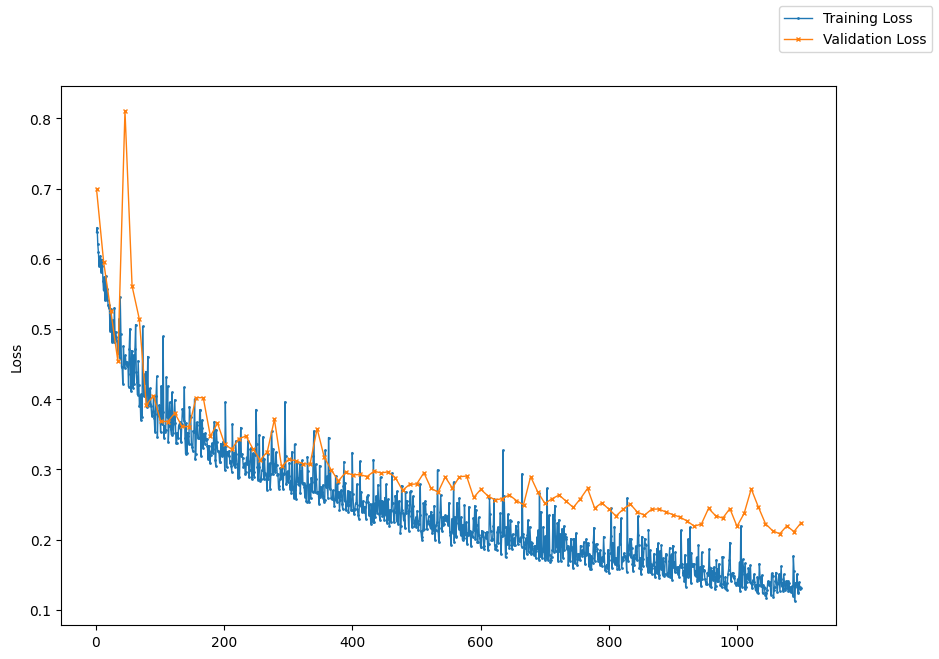

In [92]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(x_train, losses, label='Training Loss', marker='o',linewidth=1, markersize=1)
ax.plot(x_validation, f(x_validation), label='Validation Loss', marker='x',linewidth=1, markersize=3)
ax.set_ylabel('Loss')
fig.legend()
fig.show()

## Test some output results

In [141]:
with torch.no_grad():
    out_example = net(batch[0].to(device))
    out_example = torch.nn.Sigmoid()(out_example)

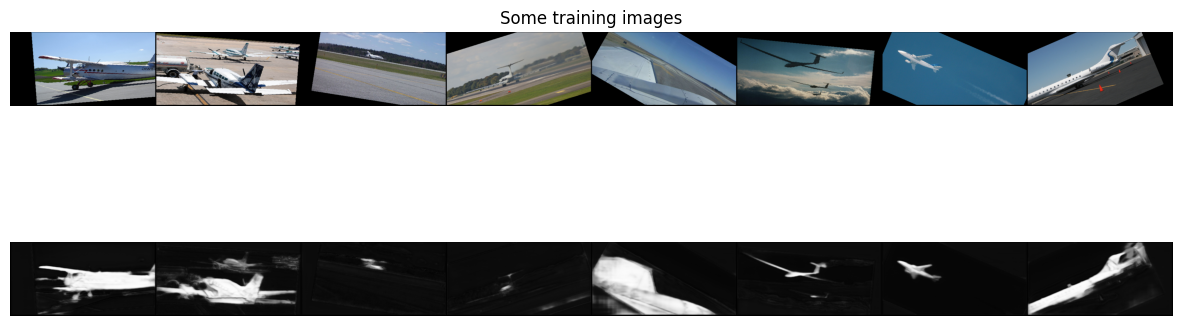

In [142]:
fig, ax = plt.subplots(2, figsize=(15, 5))
ax[0].axis("off")
ax[1].axis("off")
ax[0].set_title("Some training images")
ax[0].imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=4, normalize=True).cpu(),(1,2,0)))
ax[1].imshow(np.transpose(vutils.make_grid(out_example[:64], padding=4, normalize=True).cpu(),(1,2,0)))

In [143]:
with torch.no_grad():
    out_example = net(val_batch[0].to(device))
    out_example = torch.nn.Sigmoid()(out_example)

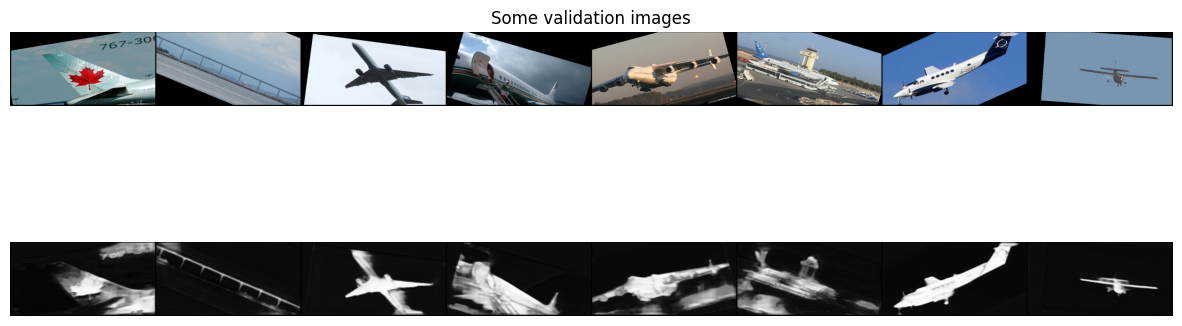

In [144]:
fig, ax = plt.subplots(2, figsize=(15, 5))
ax[0].axis("off")
ax[1].axis("off")
ax[0].set_title("Some validation images")
ax[0].imshow(np.transpose(vutils.make_grid(val_batch[0].to(device)[:64], padding=4, normalize=True).cpu(),(1,2,0)))
ax[1].imshow(np.transpose(vutils.make_grid(out_example[:64], padding=4, normalize=True).cpu(),(1,2,0)))

In [ ]:
# torch.save(net.state_dict(), '/kaggle/working/model.pth')